In [1]:
!sudo apt install -y tesseract-ocr
!pip install pytesseract transformers datasets evaluate seqeval tensorboard
!sudo apt-get install git-lfs --yes


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,153 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
import pytesseract
from PIL import Image
from huggingface_hub import notebook_login

notebook_login()


In [3]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

In [4]:
from datasets import load_dataset


dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


funsd.py:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train dataset size: 149
Test dataset size: 50


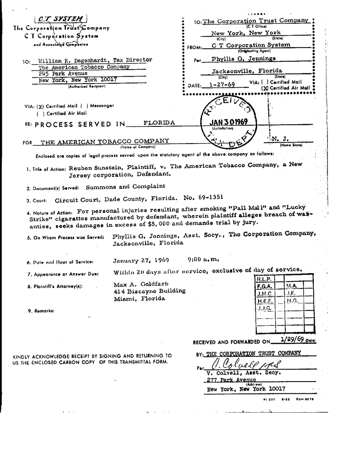

In [6]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][34]['image_path'])
image = image.convert("RGB")
image.resize((350,450))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


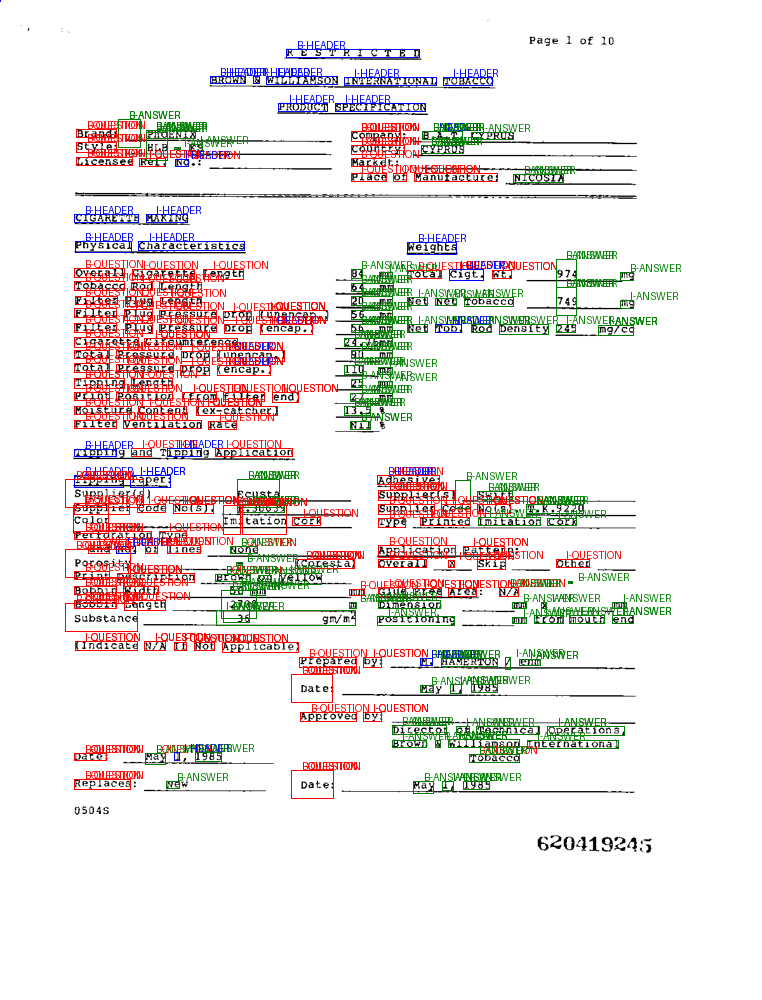

In [14]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch

model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd")
processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")


def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


def run_inference(path, model=model, processor=processor, output_image=True):
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    del encoding["image"]
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference(dataset["train"][1]["image_path"])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


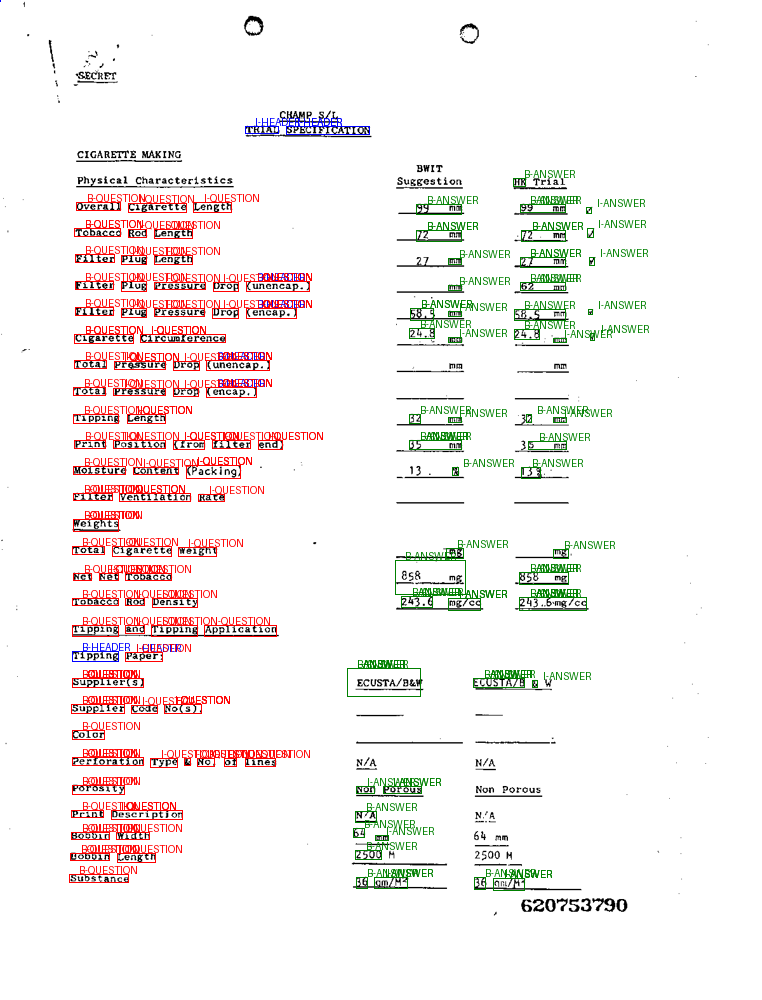

In [18]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch

model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd")
processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")


def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


def run_inference(path, model=model, processor=processor, output_image=True):
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    del encoding["image"]
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels

run_inference(dataset["train"][10]["image_path"])

In [16]:
import pytesseract
from PIL import Image, ImageDraw, ImageFont
from huggingface_hub import notebook_login
import tensorflow as tf
from datasets import load_dataset, Features, Sequence, ClassLabel, Value, Array2D
from functools import partial
from transformers import LayoutLMv2Processor, TFLayoutLMForTokenClassification
import numpy as np


dataset_id = "nielsr/funsd"
processor_id = "microsoft/layoutlmv2-base-uncased"
dataset = load_dataset(dataset_id)

labels = dataset['train'].features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding

proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
)

model_id = "microsoft/layoutlmv2-base-uncased"
model = TFLayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label,from_pt=True
)

def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

label2color = {
    "B-HEADER": "blue", "B-QUESTION": "red", "B-ANSWER": "green",
    "I-HEADER": "blue", "I-QUESTION": "red", "I-ANSWER": "green"
}

def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalized_boxes = [unnormalize_box(box, width, height) for box in boxes]
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for prediction, box in zip(predictions, normalized_boxes):
        if prediction != "O":
            draw.rectangle(box, outline=label2color[prediction])
            draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)

    return image

def run_inference(sample, model=model, processor=processor, output_image=True):
    image = Image.open(sample["image_path"]).convert("RGB")
    encoding = processor(image, sample["words"], boxes=sample["bboxes"], return_tensors="tf")

    inputs = {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "bbox": encoding["bbox"],
        "token_type_ids": encoding["token_type_ids"],
    }

    outputs = model(**inputs)
    predictions = tf.squeeze(tf.argmax(outputs.logits, axis=-1)).numpy()

    labels = [model.config.id2label[prediction] for prediction in predictions]

    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        result = [{"text": word, "label": label} for word, label in zip(sample["words"], labels)]
        return result

output_image = run_inference(dataset['train'][10])
output_image.show()

json_output = run_inference(dataset['train'][10], output_image=False)
print(json_output)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You are using a model of type layoutlmv2 to instantiate a model of type layoutlm. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFLayoutLMForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.9.conv2.norm.bias', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv3.norm.weight', 'layoutlmv2.encoder.layer.10.attention.self.v_bias', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv1.norm.moving_variance', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv1.norm.num_batches_tracked',

[{'text': 'SECRET', 'label': 'I-QUESTION'}, {'text': 'Weights', 'label': 'I-ANSWER'}, {'text': 'Supplier(s)', 'label': 'B-ANSWER'}, {'text': 'Color', 'label': 'I-ANSWER'}, {'text': 'Porosity', 'label': 'I-ANSWER'}, {'text': 'Substance', 'label': 'I-ANSWER'}, {'text': 'mm', 'label': 'I-QUESTION'}, {'text': 'mm', 'label': 'B-ANSWER'}, {'text': 'mm', 'label': 'O'}, {'text': '13%', 'label': 'B-ANSWER'}, {'text': 'mg', 'label': 'B-ANSWER'}, {'text': 'mg', 'label': 'B-ANSWER'}, {'text': 'N/A', 'label': 'B-ANSWER'}, {'text': 'N/A', 'label': 'B-QUESTION'}, {'text': 'N/A', 'label': 'O'}, {'text': 'N/A', 'label': 'B-ANSWER'}, {'text': '620753790', 'label': 'I-HEADER'}, {'text': 'CHAMP', 'label': 'I-HEADER'}, {'text': 'S/', 'label': 'B-ANSWER'}, {'text': 'L', 'label': 'I-ANSWER'}, {'text': 'TRIAL', 'label': 'I-ANSWER'}, {'text': 'SPECIFICATION', 'label': 'I-ANSWER'}, {'text': 'BWIT', 'label': 'I-ANSWER'}, {'text': 'Suggestion', 'label': 'I-ANSWER'}, {'text': 'HK', 'label': 'B-ANSWER'}, {'text': '

In [17]:
import json

output_file_path = "inference_output10.json"
with open(output_file_path, "w") as json_file:
    json.dump(json_output, json_file, indent=4)

print(f"JSON output saved to {output_file_path}")


JSON output saved to inference_output10.json
